In [2]:
import os
import sys
if "projects" not in os.getcwd():
  !git clone --depth 1 https://github.com/hoenizhuyn/EfficientDet-vinbigdatacoco.git
  os.chdir('EfficientDet-vinbigdatacoco')
  sys.path.append('.')
else:
  !git pull


fatal: destination path 'EfficientDet-vinbigdatacoco' already exists and is not an empty directory.


In [7]:
import os
import requests
import zipfile

# Create directories for datasets and weights
os.makedirs('datasets/vindata', exist_ok=True)

# Download dataset using requests
url = "https://github.com/hoenizhuyn/EfficientDet-vinbigdatacoco/releases/download/datasetv2/vindata.zip"
response = requests.get(url)

# Save the downloaded zip file
with open('vindata.zip', 'wb') as f:
    f.write(response.content)

# Unzip the dataset
with zipfile.ZipFile('vindata.zip', 'r') as zip_ref:
    zip_ref.extractall('datasets/vindata/')

# Optional: Clean up by removing the zip file
os.remove('vindata.zip')

# Display the content of vindata.yml (assuming the file exists)
!cat projects/vindata.yml


project_name: vindata # also the folder name of the dataset that under data_path folder
train_set: train
val_set: val
num_gpus: 1

# mean and std in RGB order, actually this part should remain unchanged as long as your dataset is similar to coco.
mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]

# this anchor is adapted to the dataset
anchors_scales: '[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]'
anchors_ratios: '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]'

obj_list:  [ 'Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis' ]


In [8]:
# download pretrained weights
# Create the weights directory if it doesn't exist
os.makedirs('weights', exist_ok=True)

# Download the pretrained weights using requests
url = "https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth"
response = requests.get(url)

# Save the downloaded file
with open('weights/efficientdet-d0.pth', 'wb') as f:
    f.write(response.content)


In [12]:
#SET CORRECT DATAPATH
!mkdir datasets/vindata/train/
!mkdir datasets/vindata/val/
!mv datasets/vindata/train_images datasets/vindata/train/
!mv datasets/vindata/val_images datasets/vindata/val/

mkdir: cannot create directory 'datasets/vindata/train/': File exists
mkdir: cannot create directory 'datasets/vindata/val/': File exists
mv: cannot stat 'datasets/vindata/train_images': No such file or directory
mv: cannot stat 'datasets/vindata/val_images': No such file or directory


In [13]:
import os
os.rename("datasets/vindata/annotations/instances_train_images.json", "datasets/vindata/annotations/instances_train.json")
os.rename("datasets/vindata/annotations/instances_val_images.json", "datasets/vindata/annotations/instances_val.json")

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_VISIBLE_DEVICES"]="3,4,6"  # specify which GPU(s) to be used

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


1.12.1+cu102
True


In [7]:
! python train.py -c 0 -p vindata --head_only True --lr 5e-3 --batch_size 32 --load_weights last --num_epochs 40 --save_interval 50

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
using weights logs//vindata/efficientdet-d0_24_5100.pth
[Info] loaded weights: efficientdet-d0_24_5100.pth, resuming checkpoint from step: 5100
[Info] freezed backbone


In [4]:
import os
print(os.getcwd())
#GET INTO CORRECT WORKING DIRECTORY
os.chdir('/storage/student4/huyen/EfficientDet-vinbigdatacoco')
print(os.getcwd())

/storage/student4/huyen
/storage/student4/huyen/EfficientDet-vinbigdatacoco


In [ ]:
import torch
torch.cuda.empty_cache()

In [5]:
#continue from latest epoch(due to disruption)
#reduce batch size: https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
!CUDA_VISIBLE_DEVICES=1,2,3,4 python train.py -c 0 -p vindata --head_only False --lr 1e-3 --batch_size 16 --load_weights last --num_epochs 50 --save_interval 100

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
using weights logs//vindata/efficientdet-d0_29_6000.pth
[Info] loaded weights: efficientdet-d0_29_6000.pth, resuming checkpoint from step: 6000
Step: 6099. Epoch: 29/50. Iteration: 126/206. Cls loss: 0.58376. Reg loss: 2.364checkpoint...
Step: 6179. Epoch: 29/50. Iteration: 206/206. Cls loss: 0.56574. Reg loss: 2.907
Val. Epoch: 29/50. Classification loss: 0.61593. Regression loss: 2.97817. Total loss: 3.59410
Step: 6199. Epoch: 30/50. Iteration: 20/206. Cls loss: 0.59308. Reg loss: 2.8547checkpoint...
Step: 6299. Epoch: 30/50. Iteration: 120/206. Cls loss: 0.57987. Reg loss: 2.725checkpoint...
Step: 6385. Epoch: 30/50. Iteration: 206/206. Cls loss: 0.52586. Reg loss: 3.088
Val. Epoch: 30/50. Classification loss: 0.68810. Regression loss: 2.93633. Total loss: 3.62444
Step: 6399. Epoch: 31/50. Iteration: 14/206. Cls loss: 0

In [6]:
#get latest weight file
%cd logs/vindata
weight_file = !ls -Art | grep efficientdet
%cd ../..

#choose the latest weight file
weight_file[-1] = 'efficientdet-d0_49_10300.pth'

! python coco_eval.py -c 0 -p vindata -w "logs/vindata/{weight_file[-1]}"

/storage/student4/huyen/EfficientDet-vinbigdatacoco/logs/vindata
/storage/student4/huyen/EfficientDet-vinbigdatacoco
running coco-style evaluation on project vindata, weights logs/vindata/efficientdet-d0_49_10300.pth...
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
100%|███████████████████████████████████████| 1098/1098 [02:07<00:00,  8.63it/s]
Loading and preparing results...
DONE (t=1.12s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.83s).
Accumulating evaluation results...
DONE (t=1.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


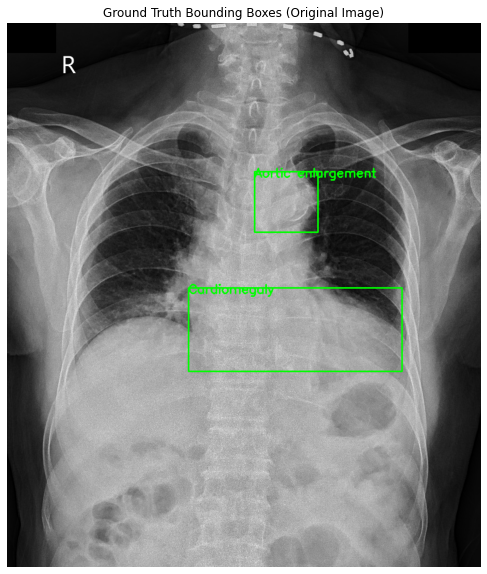

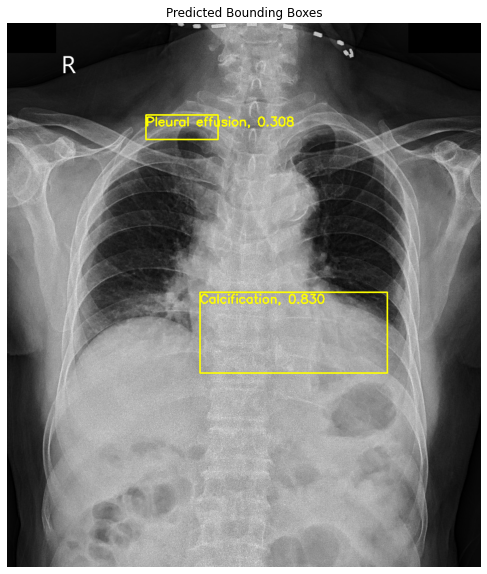

In [46]:
import torch
from torch.backends import cudnn
from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
from pycocotools.coco import COCO

# Constants
compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'datasets/vindata/val/val_images/00675cd546313f912cadd4ad54415d69.jpg'
annotations_file = 'datasets/vindata/annotations/instances_val.json'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

# List of object classes
obj_list = [ 'Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
             'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
             'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
             'Pulmonary fibrosis' ]

# Load COCO annotations
coco = COCO(annotations_file)

# Get the image filename
img_filename = 'val_images/00675cd546313f912cadd4ad54415d69.jpg'
# Now find the image id corresponding to the filename
img_id = None
for img_info in coco.dataset['images']:
    if img_info['file_name'] == img_filename:
        img_id = img_info['id']
        break  # Stop once we find the correct image
        
annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

#print(annotations)


# Load original image without resizing for true bounding box visualization
original_img = cv2.imread(img_path)
gt_img = original_img.copy()  # Copy for visualization

# Draw ground truth boxes on original size image (gt_img)
for ann in annotations:
    x1, y1, width, height = ann['bbox']
    x2, y2 = x1 + width, y1 + height
    # Draw the ground truth bounding box
    cv2.rectangle(gt_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
     
    obj = obj_list[ann['category_id']]  # Ensure category_id maps correctly
    cv2.putText(gt_img, obj,
                (int(x1), int(y1) + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                (0, 255, 0), 2)

# Display ground truth bounding boxes on original image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display in Matplotlib
plt.title("Ground Truth Bounding Boxes (Original Image)")
plt.axis('off')
plt.show()

# Preprocessing for model input
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

# Prepare input tensor
if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

# Load the model
model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=[(1.0, 1.0), (1.3, 0.8), (1.9, 0.5)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/vindata/'+weight_file[-1]))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

# Inference
with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold)

out = invert_affine(framed_metas, out)

# Visualization of model predictions on preprocessed image
for i in range(len(ori_imgs)):
    # Skip if there are no predicted boxes
    if len(out[i]['rois']) == 0:
        continue

    pred_img = ori_imgs[i].copy()  # Copy for visualization

    # Draw predicted bounding boxes on pred_img
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(int)
        cv2.rectangle(pred_img, (x1, y1), (x2, y2), (255, 255, 0), 2)  # Yellow for predictions
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(pred_img, '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (255, 255, 0), 2)

    # Display predicted bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_img)
    plt.title("Predicted Bounding Boxes")
    plt.axis('off')
    plt.show()
